In [1]:
import seaborn as sns
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from scipy import stats

In [3]:
import os

In [4]:
from scvi_colab import install
install(run_outside_colab=True)


INFO     scvi-colab: Installing scvi-tools.                                                                        
INFO     scvi-colab: Install successful. Testing import.                                                           


C:\Users\Daniel\anaconda3\envs\Finances\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")
C:\Users\Daniel\anaconda3\envs\Finances\lib\site-packages\scvi\_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
C:\Users\Daniel\anaconda3\envs\Finances\lib\site-packages\scvi\_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
C:\Users\Daniel\anaconda3\envs\Finances\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
import torch

In [6]:
import scvi

In [7]:
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

Global seed set to 0


Last run with scvi-tools version: 1.0.4


# save cleaned anndata and meta data file

In [3]:
meta_clinical = pd.read_csv('../ROSMAP/metadata/ROSMAP_clinical.csv')

In [4]:
meta_clinical.head()

,projid,Study,msex,educ,race,spanish,apoe_genotype,age_at_visit_max,age_first_ad_dx,age_death,cts_mmse30_first_ad_dx,cts_mmse30_lv,pmi,braaksc,ceradsc,cogdx,dcfdx_lv,individualID
0,10101589,ROS,1.0,20.0,1.0,2.0,34.0,90+,90+,90+,18.0,5.0,9.916667,4.0,2.0,4.0,4.0,R6939144
1,86767530,MAP,0.0,10.0,1.0,2.0,33.0,90+,90+,90+,18.0,10.0,6.500000,4.0,2.0,4.0,4.0,R3893503
2,9650662,MAP,0.0,15.0,1.0,2.0,23.0,90+,90+,90+,0.0,0.0,3.850000,3.0,2.0,4.0,4.0,R8937093
3,50402855,MAP,0.0,21.0,1.0,2.0,33.0,90+,NaN,NaN,NaN,27.0,NaN,NaN,NaN,NaN,1.0,R7139444
4,20544321,ROS,0.0,16.0,1.0,2.0,23.0,90+,90+,NaN,13.0,14.0,NaN,NaN,NaN,NaN,4.0,R4971237


In [16]:
filtered_col = pd.read_csv('../ROSMAP/filtered_column_metadata.txt',sep='\t')
filtered_genes = pd.read_csv('../ROSMAP/filtered_gene_row_names.txt',sep='\t',header=None)

In [17]:
filtered_mtx = sc.read_mtx('../ROSMAP/filtered_count_matrix.mtx',dtype='float32')

In [7]:
filtered_col.head()

,TAG,projid,tsne1,tsne2,pre.cluster,broad.cell.type,Subcluster
0,AAACGGGAGATCCCGC.1,11409232,18.076541,43.899396,15,Ex,Ex8
1,AAATGCCTCCAATGGT.1,11409232,8.130535,20.687424,3,Ex,Ex0
2,AACCATGTCAGTGCAT.1,11409232,17.088242,47.272289,15,Ex,Ex8
3,AACCATGTCTGTACGA.1,11409232,15.482062,23.718378,3,Ex,Ex0
4,AACCGCGTCCGCATAA.1,11409232,28.993102,16.223905,2,Ex,Ex0


In [8]:
filtered_col.shape

(70634, 7)

In [9]:
filtered_genes.shape

(17926, 1)

In [10]:
filtered_genes.head()

,0
0,FO538757.2
1,SAMD11
2,NOC2L
3,KLHL17
4,PLEKHN1


In [11]:
filtered_mtx

AnnData object with n_obs × n_vars = 17926 × 70634

In [18]:
filtered_mtx = filtered_mtx.T

In [13]:
filtered_mtx

AnnData object with n_obs × n_vars = 70634 × 17926

In [14]:
filtered_mtx.X

<70634x17926 sparse matrix of type '<class 'numpy.float32'>'
	with 119696200 stored elements in Compressed Sparse Column format>

In [19]:
filtered_mtx.obs = filtered_col

In [20]:
filtered_mtx.var = filtered_genes

In [21]:
filtered_mtx.var = filtered_mtx.var.rename(columns={0:'gene_name'})

In [24]:
filtered_mtx

AnnData object with n_obs × n_vars = 70634 × 17926
    obs: 'TAG', 'projid', 'pre.cluster', 'broad.cell.type', 'Subcluster'
    var: 'gene_name'
    obsm: 'tsne'

In [22]:
filtered_mtx.obsm['tsne'] = filtered_col[['tsne1','tsne2']]

In [23]:
filtered_mtx.obs.drop(columns=['tsne1','tsne2'],inplace=True)

In [29]:
sample_id = filtered_col.projid.unique()

In [34]:
meta_rnaseq = meta_clinical[meta_clinical.projid.isin(sample_id)].copy()

In [35]:
meta_rnaseq

,projid,Study,msex,educ,race,spanish,apoe_genotype,age_at_visit_max,age_first_ad_dx,age_death,cts_mmse30_first_ad_dx,cts_mmse30_lv,pmi,braaksc,ceradsc,cogdx,dcfdx_lv,individualID
25,20104101,ROS,0.0,18.0,1.0,2.0,23.0,90+,90+,90+,25.0,0.0,4.500000,2.0,3.0,4.0,4.0,R4567280
272,20207013,ROS,0.0,23.0,1.0,2.0,23.0,90+,NaN,90+,NaN,27.0,4.166667,1.0,4.0,1.0,1.0,R2880377
282,20170043,ROS,0.0,24.0,1.0,2.0,33.0,90+,83.723477070499655,90+,27.0,0.0,4.250000,5.0,1.0,4.0,4.0,R9094222
616,20977678,ROS,0.0,16.0,1.0,2.0,23.0,90+,NaN,90+,NaN,1.0,3.916667,3.0,4.0,2.0,2.0,R9113571
648,20149910,ROS,0.0,18.0,1.0,2.0,23.0,90+,NaN,90+,NaN,27.0,3.250000,4.0,4.0,1.0,1.0,R3405776
688,20173942,ROS,0.0,21.0,1.0,2.0,34.0,90+,NaN,90+,NaN,13.0,18.166667,4.0,1.0,4.0,5.0,R3884524
756,21189544,ROS,0.0,18.0,1.0,2.0,23.0,90+,86.92402464065708,90+,21.0,3.0,4.250000,5.0,1.0,4.0,4.0,R4042599
815,20261901,ROS,0.0,20.0,1.0,2.0,33.0,90+,90+,90+,19.0,17.0,7.750000,5.0,2.0,4.0,5.0,R8629052
818,21135554,ROS,0.0,21.0,1.0,2.0,33.0,90+,90+,90+,13.0,10.0,16.933333,5.0,2.0,4.0,4.0,R5885245
860,21126823,ROS,0.0,18.0,1.0,2.0,33.0,90+,NaN,90+,NaN,27.0,6.283333,1.0,4.0,2.0,2.0,R6267541


In [36]:
meta_rnaseq.msex.value_counts() #sample balance on sex

msex
0.0    24
1.0    24
Name: count, dtype: int64

In [38]:
meta_rnaseq.race.value_counts() #sample focus on white

race
1.0    46
2.0     2
Name: count, dtype: int64

In [39]:
meta_rnaseq.spanish.value_counts() #sample mostly no spanish

spanish
2.0    46
1.0     2
Name: count, dtype: int64

In [40]:
meta_rnaseq.apoe_genotype.value_counts()

apoe_genotype
33.0    23
23.0    11
34.0     9
44.0     4
Name: count, dtype: int64

In [41]:
meta_rnaseq.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48 entries, 25 to 3285
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   projid                  48 non-null     int64  
 1   Study                   48 non-null     object 
 2   msex                    48 non-null     float64
 3   educ                    48 non-null     float64
 4   race                    48 non-null     float64
 5   spanish                 48 non-null     float64
 6   apoe_genotype           47 non-null     float64
 7   age_at_visit_max        48 non-null     object 
 8   age_first_ad_dx         17 non-null     object 
 9   age_death               48 non-null     object 
 10  cts_mmse30_first_ad_dx  17 non-null     float64
 11  cts_mmse30_lv           48 non-null     float64
 12  pmi                     47 non-null     float64
 13  braaksc                 48 non-null     float64
 14  ceradsc                 48 non-null     float6

In [43]:
meta_rnaseq['age_at_visit_max'] = meta_rnaseq['age_at_visit_max'].astype(str).str.replace('+', '').astype('float')
meta_rnaseq['age_first_ad_dx'] = meta_rnaseq['age_first_ad_dx'].astype(str).str.replace('+', '').astype('float')
meta_rnaseq['age_death'] = meta_rnaseq['age_death'].astype(str).str.replace('+', '').astype('float')

<Axes: xlabel='braaksc', ylabel='age_death'>

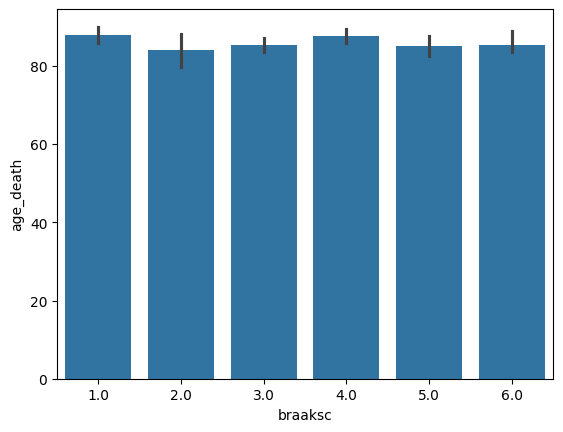

In [44]:
sns.barplot(meta_rnaseq,x='braaksc',y='age_death')

<Axes: xlabel='ceradsc', ylabel='age_death'>

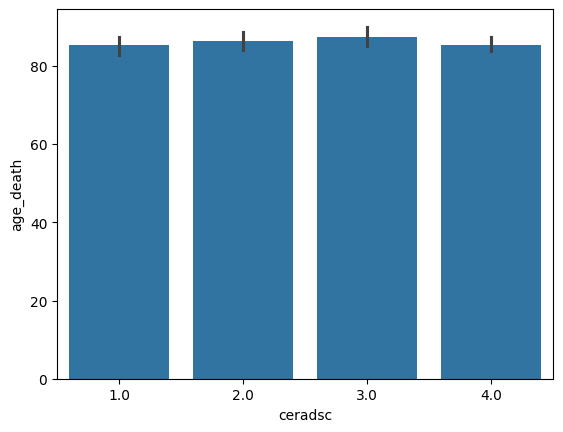

In [45]:
sns.barplot(meta_rnaseq,x='ceradsc',y='age_death')

<Axes: xlabel='braaksc', ylabel='cts_mmse30_lv'>

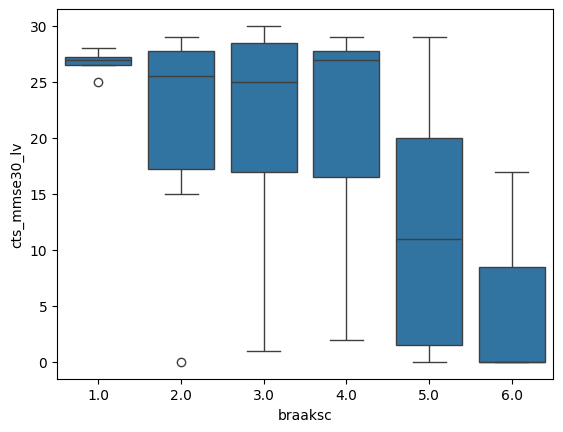

In [50]:
sns.boxplot(meta_rnaseq,x='braaksc',y='cts_mmse30_lv')

<Axes: xlabel='ceradsc', ylabel='cts_mmse30_lv'>

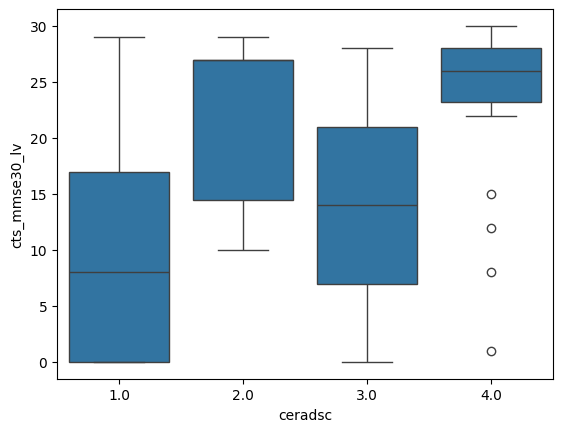

In [49]:
sns.boxplot(meta_rnaseq,x='ceradsc',y='cts_mmse30_lv')

<Axes: xlabel='braaksc', ylabel='cogdx'>

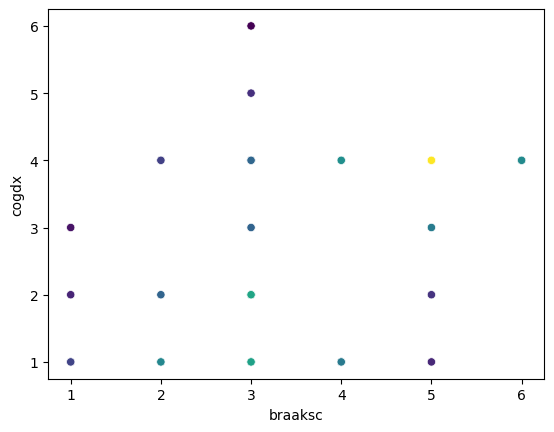

In [57]:
values = np.vstack([meta_rnaseq["braaksc"], meta_rnaseq["cogdx"]])
kernel = stats.gaussian_kde(values)(values)
sns.scatterplot(data=meta_rnaseq,x='braaksc',y='cogdx',c=kernel,cmap="viridis")

<Axes: xlabel='braaksc', ylabel='cogdx'>

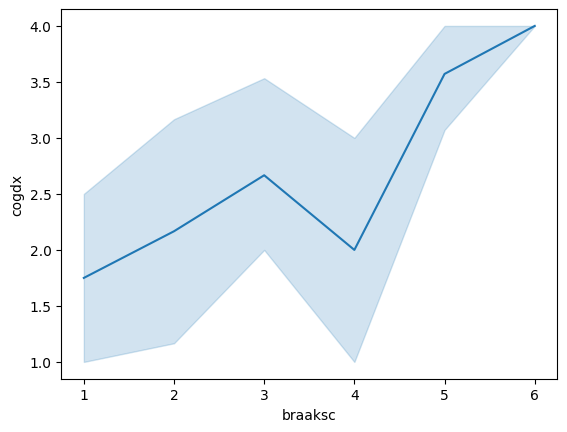

In [58]:
sns.lineplot(data=meta_rnaseq,x='braaksc',y='cogdx')

<Axes: xlabel='ceradsc', ylabel='cogdx'>

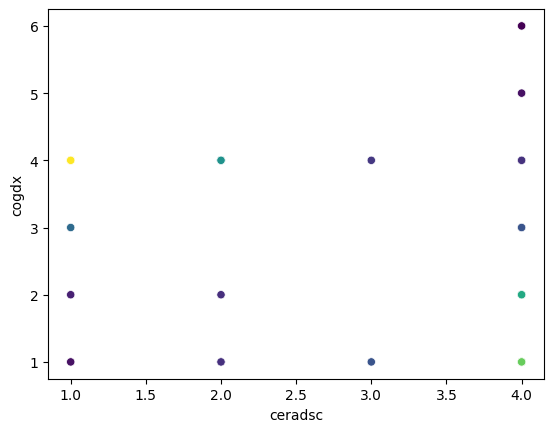

In [59]:
values = np.vstack([meta_rnaseq["ceradsc"], meta_rnaseq["cogdx"]])
kernel = stats.gaussian_kde(values)(values)
sns.scatterplot(data=meta_rnaseq,x='ceradsc',y='cogdx',c=kernel,cmap="viridis")

<Axes: xlabel='ceradsc', ylabel='cogdx'>

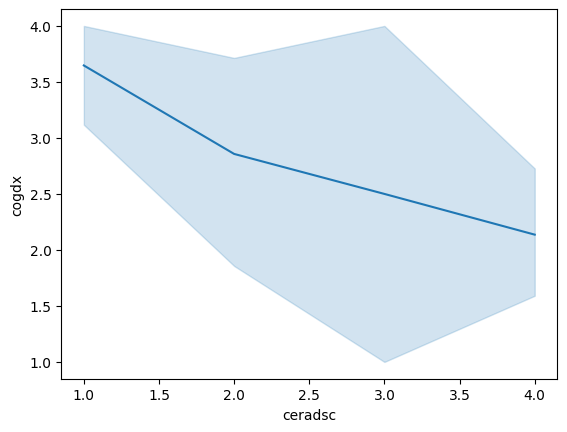

In [60]:
sns.lineplot(data=meta_rnaseq,x='ceradsc',y='cogdx')

<Axes: xlabel='braaksc', ylabel='dcfdx_lv'>

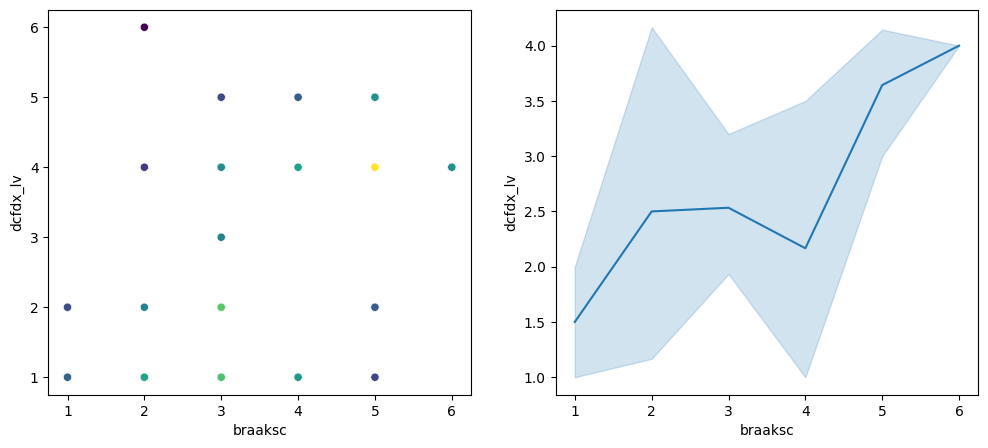

In [72]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12, 5))
values = np.vstack([meta_rnaseq["braaksc"], meta_rnaseq["dcfdx_lv"]])
kernel = stats.gaussian_kde(values)(values)
sns.scatterplot(data=meta_rnaseq,x='braaksc',y='dcfdx_lv',c=kernel,cmap="viridis",ax=ax1)
sns.lineplot(data=meta_rnaseq,x='braaksc',y='dcfdx_lv',ax=ax2)

<Axes: xlabel='ceradsc', ylabel='dcfdx_lv'>

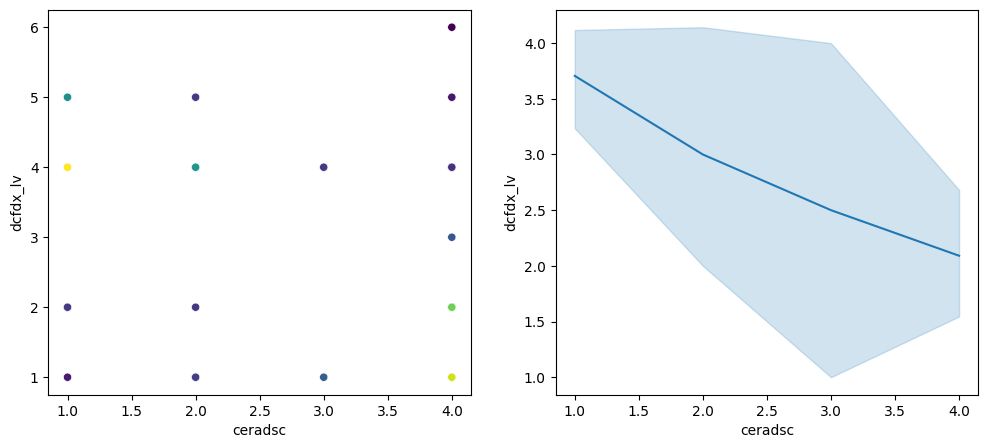

In [73]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12, 5))
values = np.vstack([meta_rnaseq["ceradsc"], meta_rnaseq["dcfdx_lv"]])
kernel = stats.gaussian_kde(values)(values)
sns.scatterplot(data=meta_rnaseq,x='ceradsc',y='dcfdx_lv',c=kernel,cmap="viridis",ax=ax1)
sns.lineplot(data=meta_rnaseq,x='ceradsc',y='dcfdx_lv',ax=ax2)

In [82]:
meta_rnaseq.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48 entries, 25 to 3285
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   projid                  48 non-null     int64  
 1   Study                   48 non-null     object 
 2   msex                    48 non-null     float64
 3   educ                    48 non-null     float64
 4   race                    48 non-null     float64
 5   spanish                 48 non-null     float64
 6   apoe_genotype           47 non-null     float64
 7   age_at_visit_max        48 non-null     float64
 8   age_first_ad_dx         17 non-null     float64
 9   age_death               48 non-null     float64
 10  cts_mmse30_first_ad_dx  17 non-null     float64
 11  cts_mmse30_lv           48 non-null     float64
 12  pmi                     47 non-null     float64
 13  braaksc                 48 non-null     float64
 14  ceradsc                 48 non-null     float6

In [83]:
ad_col = ['msex','age_at_visit_max','age_death','cts_mmse30_lv','braaksc','ceradsc','cogdx','dcfdx_lv']

In [84]:
meta_rnaseq[ad_col].corr()

,msex,age_at_visit_max,age_death,cts_mmse30_lv,braaksc,ceradsc,cogdx,dcfdx_lv
msex,1.000000,-0.207369,-0.164532,0.178987,-0.134358,0.045776,-0.206329,-0.153266
age_at_visit_max,-0.207369,1.000000,0.954477,-0.249231,-0.070807,0.060838,0.076497,0.099718
age_death,-0.164532,0.954477,1.000000,-0.183175,-0.047263,-0.013129,0.026274,0.045682
cts_mmse30_lv,0.178987,-0.249231,-0.183175,1.000000,-0.473066,0.501791,-0.714721,-0.729902
braaksc,-0.134358,-0.070807,-0.047263,-0.473066,1.000000,-0.782013,0.422871,0.423709
ceradsc,0.045776,0.060838,-0.013129,0.501791,-0.782013,1.000000,-0.474497,-0.485376
cogdx,-0.206329,0.076497,0.026274,-0.714721,0.422871,-0.474497,1.000000,0.947467
dcfdx_lv,-0.153266,0.099718,0.045682,-0.729902,0.423709,-0.485376,0.947467,1.000000


<Axes: xlabel='ceradsc', ylabel='braaksc'>

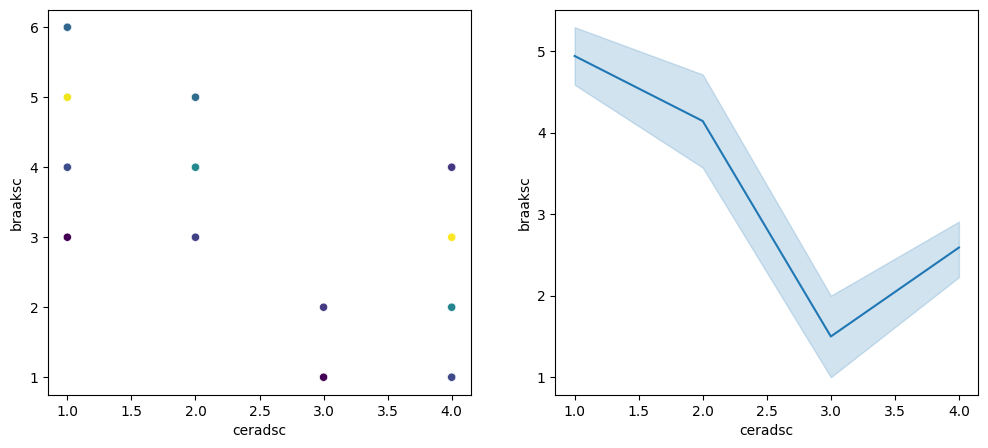

In [79]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12, 5))
values = np.vstack([meta_rnaseq["ceradsc"], meta_rnaseq["braaksc"]])
kernel = stats.gaussian_kde(values)(values)
sns.scatterplot(data=meta_rnaseq,x='ceradsc',y='braaksc',c=kernel,cmap="viridis",ax=ax1)
sns.lineplot(data=meta_rnaseq,x='ceradsc',y='braaksc',ax=ax2)

### braaksc and ceradsc are correlated with coef~-0.8
### cogdx and dcfdx_lv are highly correlated (0.95)
### cogdx/dcfdx_lv are correlated with braaksc/ceradsc with coef ~+-0.45
### cts_mmse30_lv is correlated with cogdx/dcfdx_lv with coef~ -0.7, correlated with braaksc/ceradsc with coef~ +-0.5
### no obvious corr with age and sex

In [88]:
os.makedirs('../cleaned_file', exist_ok=True) 
meta_rnaseq.to_csv('../cleaned_file/meta_rnaseq.csv')

In [ ]:
filtered_mtx.obs_names = [f"Cell_{i:d}" for i in range(filtered_mtx.n_obs)]
filtered_mtx.var_names = [f"Gene_{i:d}" for i in range(filtered_mtx.n_vars)]

In [52]:
filtered_mtx.write("../cleaned_file/filtered_mtx.h5ad", compression="gzip")

# quality checking

In [14]:
meta_rnaseq=pd.read_csv('../cleaned_file/meta_rnaseq.csv',index_col=0)

In [15]:
meta_rnaseq.head()

,projid,Study,msex,educ,race,spanish,apoe_genotype,age_at_visit_max,age_first_ad_dx,age_death,cts_mmse30_first_ad_dx,cts_mmse30_lv,pmi,braaksc,ceradsc,cogdx,dcfdx_lv,individualID
25,20104101,ROS,0.0,18.0,1.0,2.0,23.0,90.0,90.000000,90.0,25.0,0.0,4.500000,2.0,3.0,4.0,4.0,R4567280
272,20207013,ROS,0.0,23.0,1.0,2.0,23.0,90.0,NaN,90.0,NaN,27.0,4.166667,1.0,4.0,1.0,1.0,R2880377
282,20170043,ROS,0.0,24.0,1.0,2.0,33.0,90.0,83.723477,90.0,27.0,0.0,4.250000,5.0,1.0,4.0,4.0,R9094222
616,20977678,ROS,0.0,16.0,1.0,2.0,23.0,90.0,NaN,90.0,NaN,1.0,3.916667,3.0,4.0,2.0,2.0,R9113571
648,20149910,ROS,0.0,18.0,1.0,2.0,23.0,90.0,NaN,90.0,NaN,27.0,3.250000,4.0,4.0,1.0,1.0,R3405776


In [53]:
filtered_mtx = sc.read_h5ad('../cleaned_file/filtered_mtx.h5ad')

In [57]:
del filtered_mtx_t

In [106]:
filtered_mtx.var[filtered_mtx.var.gene_name.str.startswith('MT')].shape

(82, 1)

In [58]:
filtered_mtx.var['mt'] = filtered_mtx.var.gene_name.str.startswith('MT')

In [59]:
sc.pp.calculate_qc_metrics(
    filtered_mtx, qc_vars=["mt"], inplace=True, percent_top=[100]
)

In [60]:
filtered_mtx

AnnData object with n_obs × n_vars = 70634 × 17926
    obs: 'TAG', 'projid', 'pre.cluster', 'broad.cell.type', 'Subcluster', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_100_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_name', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    obsm: 'tsne'

<Axes: xlabel='n_genes_by_counts', ylabel='Count'>

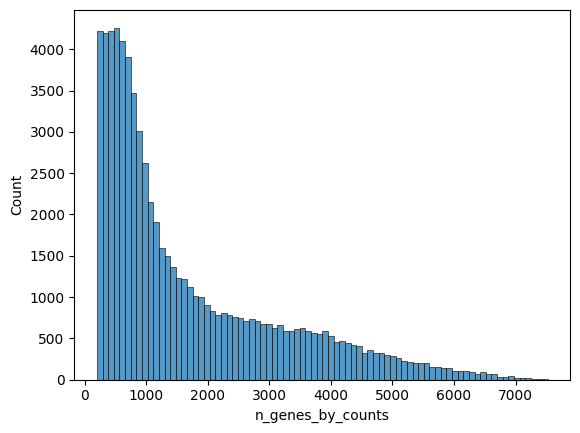

In [110]:
sns.histplot(filtered_mtx.obs, x='n_genes_by_counts')

In [111]:
filtered_mtx.obs['n_genes_by_counts'].describe()

count    70634.000000
mean      1694.597503
std       1479.018656
min        201.000000
25%        584.000000
50%       1078.000000
75%       2487.000000
max       7525.000000
Name: n_genes_by_counts, dtype: float64

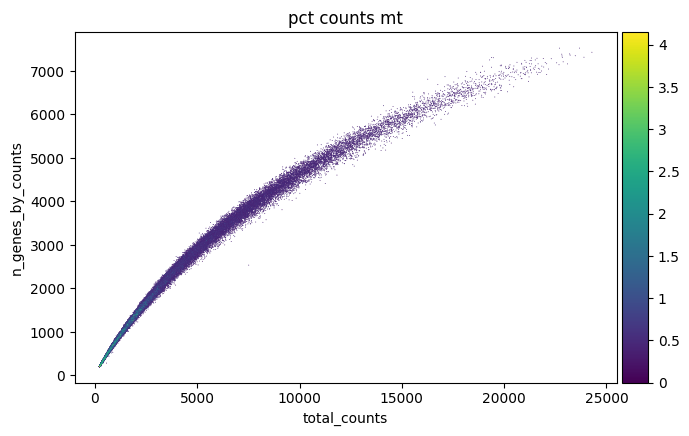

In [114]:
sc.pl.scatter(filtered_mtx, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

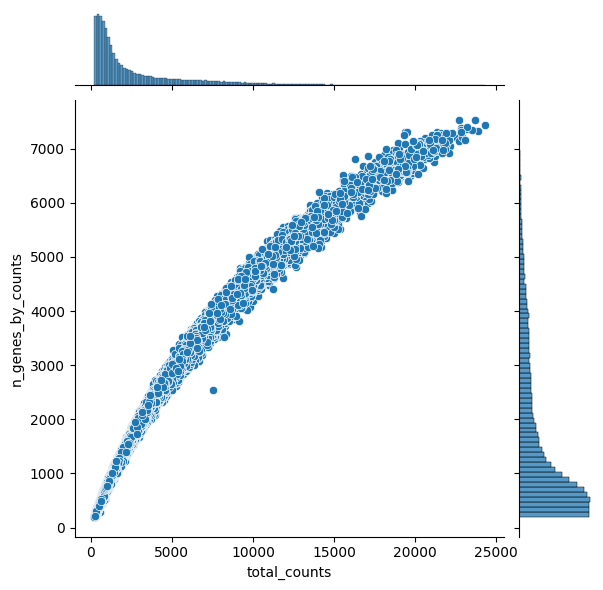

In [117]:
sns.jointplot(filtered_mtx.obs, x='total_counts',y='n_genes_by_counts')

### two points look like a outlier based on gene counts

In [119]:

filtered_mtx.obs[(filtered_mtx.obs['total_counts']>7000) & (filtered_mtx.obs['n_genes_by_counts']<3000)]

,TAG,projid,pre.cluster,broad.cell.type,Subcluster,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,total_counts_mt,log1p_total_counts_mt,pct_counts_mt
63461,TAGTTGGTCTGAGGGA.22,76647134,13,Mic,Mic0,2535,7.838343,7515.0,8.924789,15.222888,24.497671,36.939454,58.868929,29.0,3.401197,0.385895


In [120]:
filtered_mtx.obs['total_counts'].describe()

count    70634.000000
mean      3028.876465
std       3510.269043
min        206.000000
25%        727.000000
50%       1474.000000
75%       4077.000000
max      24290.000000
Name: total_counts, dtype: float64

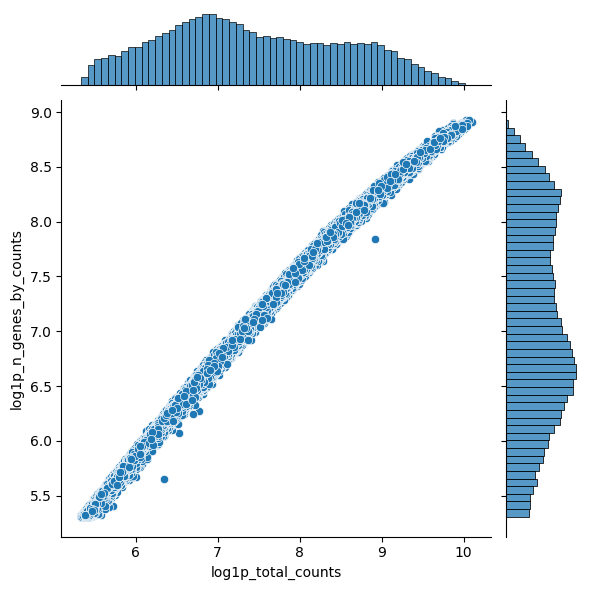

In [121]:
sns.jointplot(filtered_mtx.obs, x='log1p_total_counts',y='log1p_n_genes_by_counts')

In [122]:
filtered_mtx.obs[(filtered_mtx.obs['log1p_total_counts']>6.3) & (filtered_mtx.obs['log1p_n_genes_by_counts']<5.75)]

,TAG,projid,pre.cluster,broad.cell.type,Subcluster,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,total_counts_mt,log1p_total_counts_mt,pct_counts_mt
17578,GACGGCTTCGGATGTT.23,20179164,2,Ex,Ex8,283,5.648974,567.0,6.342122,57.319224,67.724868,85.361552,100.0,0.0,0.0,0.0


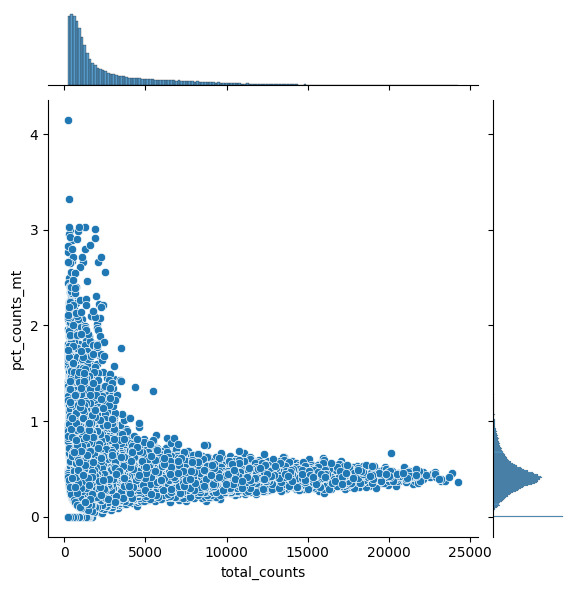

In [123]:
sns.jointplot(filtered_mtx.obs, x='total_counts',y='pct_counts_mt')

C:\Users\Daniel\anaconda3\envs\Finances\lib\site-packages\scanpy\plotting\_anndata.py:839: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


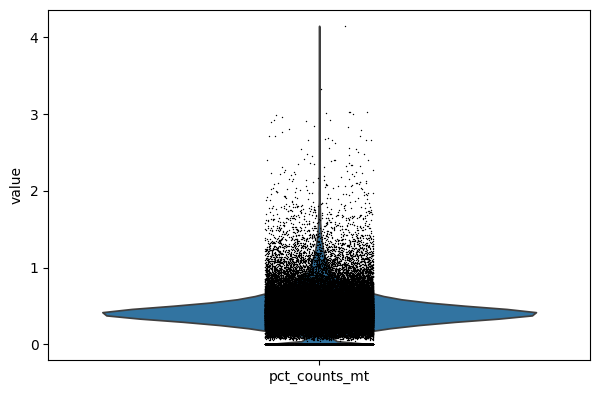

In [124]:
sc.pl.violin(filtered_mtx, "pct_counts_mt")

### look at number of cells(barcodes) measured for each donor

<Axes: >

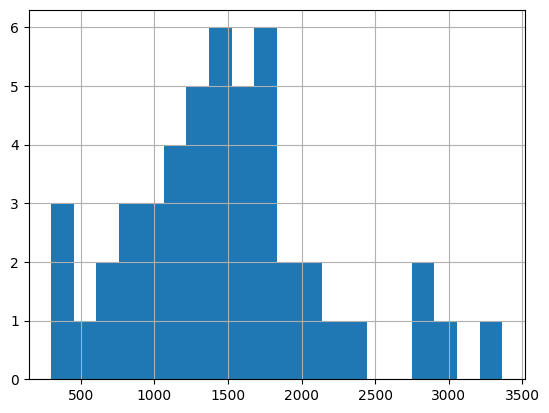

In [134]:
filtered_mtx.obs.projid.value_counts().hist(bins=20)

# dimension reduction

<Axes: xlabel='tsne1', ylabel='tsne2'>

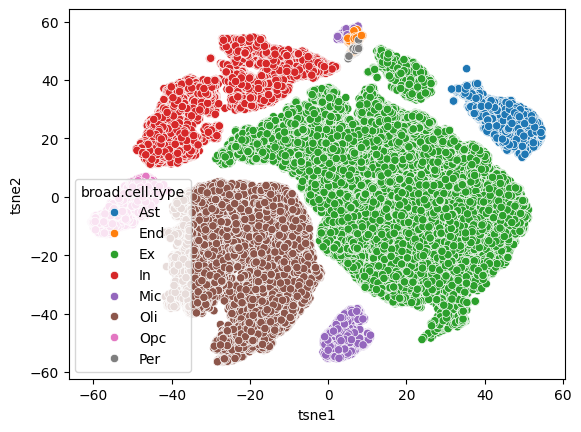

In [61]:
sns.scatterplot(filtered_mtx.obsm['tsne'],x='tsne1',y='tsne2',hue=filtered_mtx.obs['broad.cell.type'],legend='brief')


In [145]:
np.sort(filtered_mtx.obs['pre.cluster'].unique())

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       19, 20, 21], dtype=int64)

In [146]:
filtered_mtx.obs['broad.cell.type'].value_counts()

broad.cell.type
Ex     34976
Oli    18235
In      9196
Ast     3392
Opc     2627
Mic     1920
Per      167
End      121
Name: count, dtype: int64

In [149]:
filtered_mtx.obs['Subcluster'].nunique()

44

<Axes: xlabel='tsne1', ylabel='tsne2'>

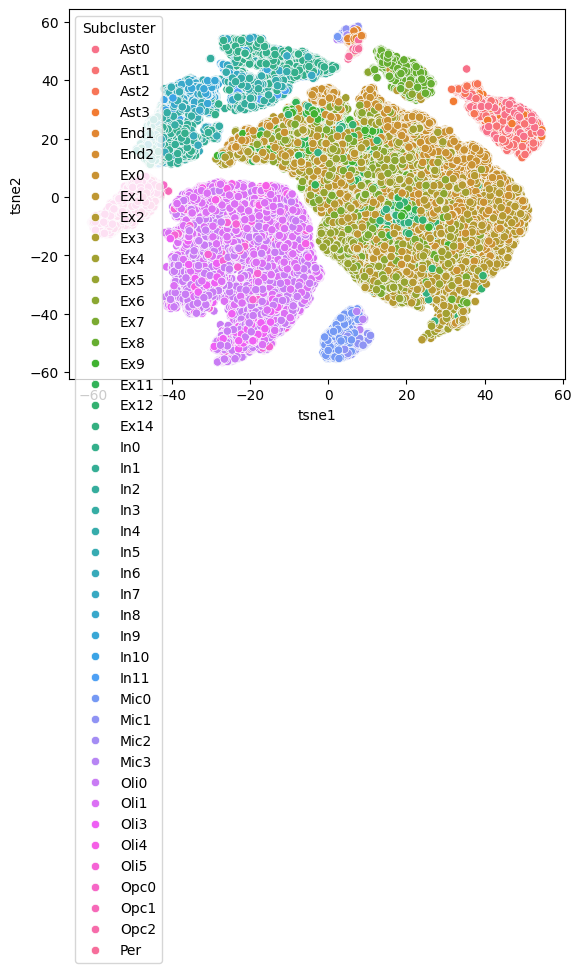

In [156]:
sns.scatterplot(filtered_mtx.obsm['tsne'],x='tsne1',y='tsne2',hue=filtered_mtx.obs['Subcluster'])

## try umap without normalization

In [62]:
sc.pp.pca(filtered_mtx)

In [158]:
filtered_mtx

AnnData object with n_obs × n_vars = 70634 × 17926
    obs: 'TAG', 'projid', 'pre.cluster', 'broad.cell.type', 'Subcluster', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_name', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'pca'
    obsm: 'tsne', 'X_pca'
    varm: 'PCs'

In [163]:
len(filtered_mtx.varm['PCs'][0])

50

In [63]:
sc.pp.neighbors(filtered_mtx,use_rep="X_pca")

In [64]:
filtered_mtx

AnnData object with n_obs × n_vars = 70634 × 17926
    obs: 'TAG', 'projid', 'pre.cluster', 'broad.cell.type', 'Subcluster', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_100_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_name', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'pca', 'neighbors'
    obsm: 'tsne', 'X_pca'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [65]:
sc.tl.umap(filtered_mtx)

In [66]:
filtered_mtx

AnnData object with n_obs × n_vars = 70634 × 17926
    obs: 'TAG', 'projid', 'pre.cluster', 'broad.cell.type', 'Subcluster', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_100_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_name', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'pca', 'neighbors', 'umap'
    obsm: 'tsne', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

C:\Users\Daniel\anaconda3\envs\Finances\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


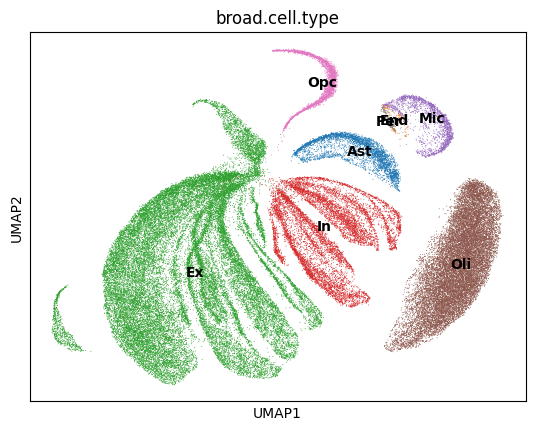

In [72]:
sc.pl.umap(filtered_mtx, color="broad.cell.type",legend_loc='on data')

C:\Users\Daniel\anaconda3\envs\Finances\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


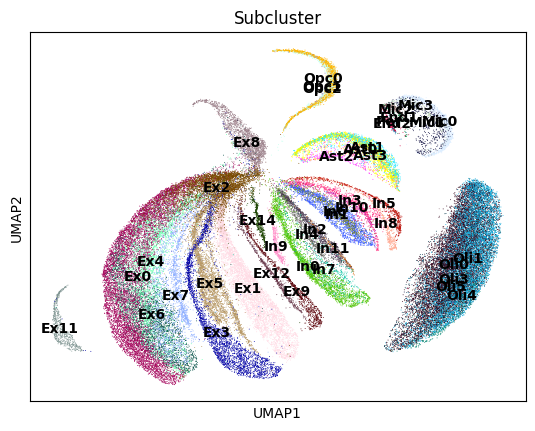

In [71]:
sc.pl.umap(filtered_mtx, color="Subcluster",legend_loc='on data')

In [76]:
filtered_mtx.obs['projid'] = filtered_mtx.obs.projid.astype('str')

C:\Users\Daniel\anaconda3\envs\Finances\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


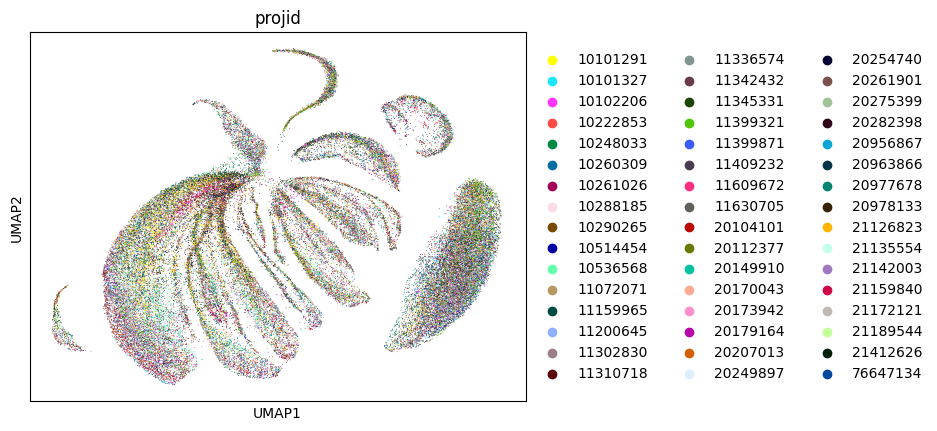

In [77]:
sc.pl.umap(filtered_mtx, color="projid")

In [85]:
meta_rnaseq.loc[(meta_rnaseq.braaksc<=2) &  (meta_rnaseq.ceradsc>=3) & (meta_rnaseq.cogdx<=2) & (meta_rnaseq.dcfdx_lv<=2),'stage']='NO_AD'

In [87]:
meta_rnaseq.loc[(meta_rnaseq.braaksc>=4) &  (meta_rnaseq.ceradsc<3) & (meta_rnaseq.cogdx>=4) & (meta_rnaseq.dcfdx_lv>=4),'stage'] = 'AD'

In [89]:
meta_rnaseq.stage.fillna(value='possible_AD',inplace=True)

In [90]:
meta_rnaseq.head()

,projid,Study,msex,educ,race,spanish,apoe_genotype,age_at_visit_max,age_first_ad_dx,age_death,cts_mmse30_first_ad_dx,cts_mmse30_lv,pmi,braaksc,ceradsc,cogdx,dcfdx_lv,individualID,stage
25,20104101,ROS,0.0,18.0,1.0,2.0,23.0,90.0,90.000000,90.0,25.0,0.0,4.500000,2.0,3.0,4.0,4.0,R4567280,possible_AD
272,20207013,ROS,0.0,23.0,1.0,2.0,23.0,90.0,NaN,90.0,NaN,27.0,4.166667,1.0,4.0,1.0,1.0,R2880377,NO_AD
282,20170043,ROS,0.0,24.0,1.0,2.0,33.0,90.0,83.723477,90.0,27.0,0.0,4.250000,5.0,1.0,4.0,4.0,R9094222,AD
616,20977678,ROS,0.0,16.0,1.0,2.0,23.0,90.0,NaN,90.0,NaN,1.0,3.916667,3.0,4.0,2.0,2.0,R9113571,possible_AD
648,20149910,ROS,0.0,18.0,1.0,2.0,23.0,90.0,NaN,90.0,NaN,27.0,3.250000,4.0,4.0,1.0,1.0,R3405776,possible_AD


In [93]:
meta_rnaseq['projid'] = meta_rnaseq.projid.astype('str')

In [98]:
merge_stage = filtered_mtx.obs[['projid']].merge(meta_rnaseq[['projid','stage']],how='left',on='projid').set_index(filtered_mtx.obs[['projid']].index)

In [99]:
filtered_mtx.obs['stage'] = merge_stage['stage']

C:\Users\Daniel\anaconda3\envs\Finances\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


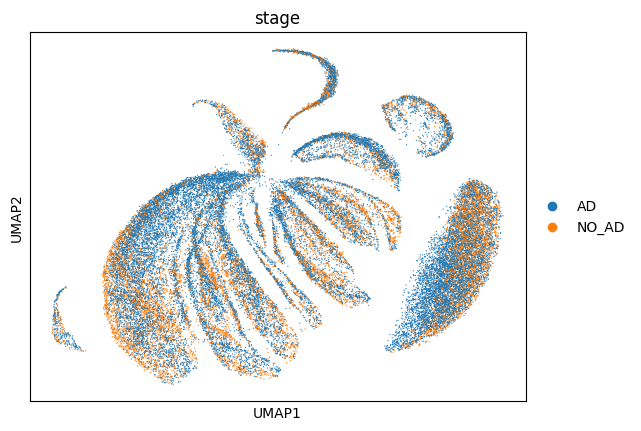

In [101]:
sc.pl.umap(filtered_mtx[filtered_mtx.obs.stage.isin(['NO_AD','AD'])], color="stage")

## try umap with normalization

In [103]:
filtered_mtx.layers['counts'] = filtered_mtx.X.copy()

In [104]:
sc.pp.normalize_total(filtered_mtx)

In [105]:
sc.pp.log1p(filtered_mtx)

In [106]:
filtered_mtx

AnnData object with n_obs × n_vars = 70634 × 17926
    obs: 'TAG', 'projid', 'pre.cluster', 'broad.cell.type', 'Subcluster', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_100_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'stage'
    var: 'gene_name', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'pca', 'neighbors', 'umap', 'broad.cell.type_colors', 'Subcluster_colors', 'projid_colors', 'stage_colors', 'log1p'
    obsm: 'tsne', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [107]:
sc.pp.pca(filtered_mtx)
sc.pp.neighbors(filtered_mtx,use_rep="X_pca")
sc.tl.umap(filtered_mtx)

Note: re-calculate umap will overwrite previous results!!

C:\Users\Daniel\anaconda3\envs\Finances\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


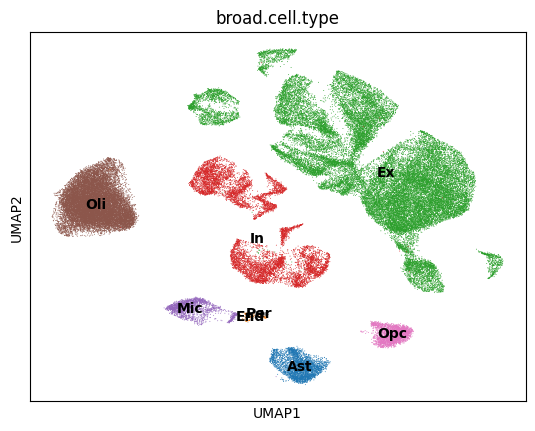

In [108]:
sc.pl.umap(filtered_mtx, color="broad.cell.type",legend_loc='on data')

In [109]:
filtered_mtx

AnnData object with n_obs × n_vars = 70634 × 17926
    obs: 'TAG', 'projid', 'pre.cluster', 'broad.cell.type', 'Subcluster', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_100_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'stage'
    var: 'gene_name', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'pca', 'neighbors', 'umap', 'broad.cell.type_colors', 'Subcluster_colors', 'projid_colors', 'stage_colors', 'log1p'
    obsm: 'tsne', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

C:\Users\Daniel\anaconda3\envs\Finances\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


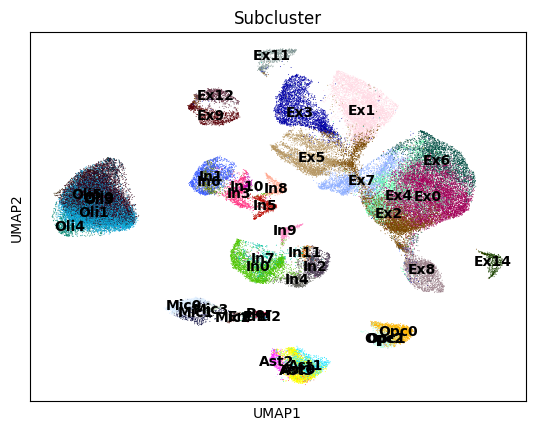

In [110]:
sc.pl.umap(filtered_mtx, color="Subcluster",legend_loc='on data')

C:\Users\Daniel\anaconda3\envs\Finances\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


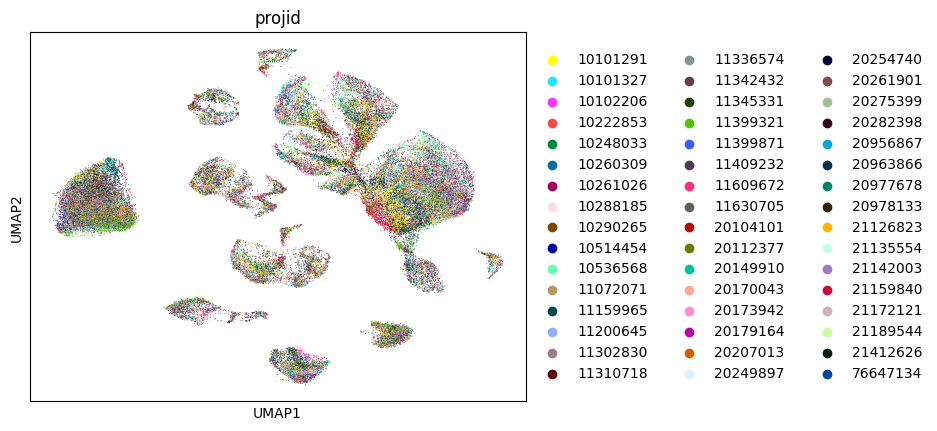

In [111]:
sc.pl.umap(filtered_mtx, color="projid")

C:\Users\Daniel\anaconda3\envs\Finances\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


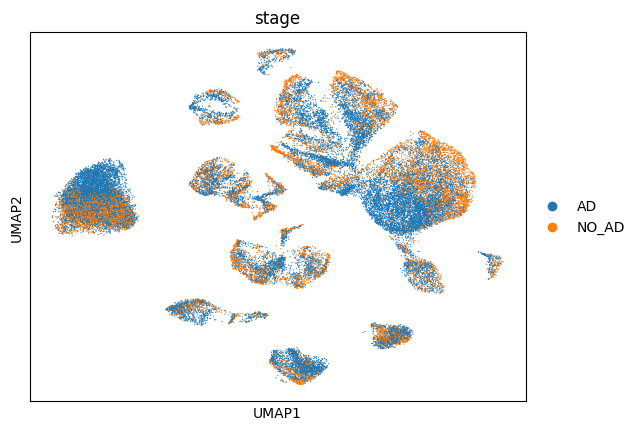

In [112]:
sc.pl.umap(filtered_mtx[filtered_mtx.obs.stage.isin(['NO_AD','AD'])], color="stage")

C:\Users\Daniel\anaconda3\envs\Finances\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


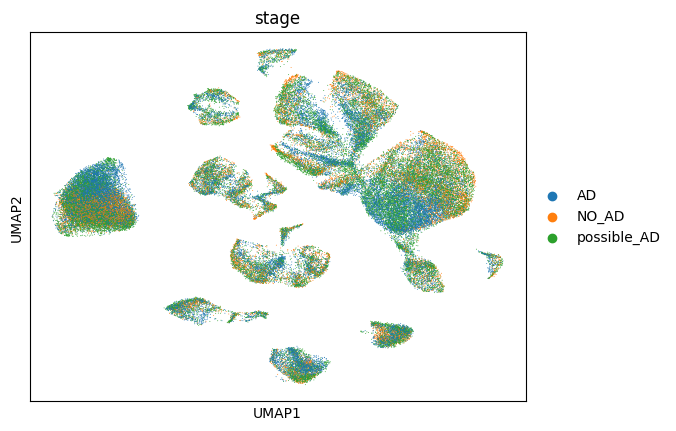

In [113]:
sc.pl.umap(filtered_mtx, color="stage")

In [114]:
filtered_mtx.layers['log1p_norm'] = filtered_mtx.X.copy()

### normalization before umap don't make large difference in seperating sub cell types
### donors are evenly distributed in umap
### can see some seperation between AD and NO_AD donor from umap

# feature selection

In [125]:
filtered_mtx.X = filtered_mtx.layers["counts"]

<Axes: xlabel='n_cells_by_counts', ylabel='Count'>

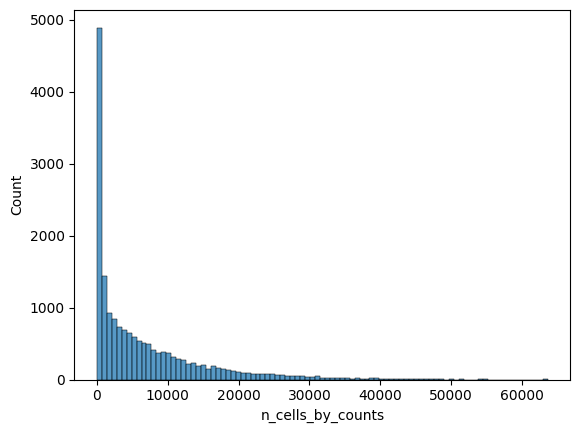

In [116]:
sns.histplot(filtered_mtx.var,x='n_cells_by_counts')

In [118]:
filtered_mtx.var

,gene_name,mt,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts
Gene_0,FO538757.2,False,14778,0.266911,0.236582,79.078064,18853.0,9.844481
Gene_1,SAMD11,False,118,0.001699,0.001697,99.832942,120.0,4.795791
Gene_2,NOC2L,False,9000,0.153354,0.142674,87.258261,10832.0,9.290352
Gene_3,KLHL17,False,1335,0.019495,0.019307,98.109975,1377.0,7.228388
Gene_4,PLEKHN1,False,17,0.000241,0.000241,99.975932,17.0,2.890372
...,...,...,...,...,...,...,...,...
Gene_17921,C21orf58,False,1730,0.025399,0.025081,97.550755,1794.0,7.492760
Gene_17922,PCNT,False,10969,0.196449,0.179358,84.470652,13876.0,9.537988
Gene_17923,DIP2A,False,13896,0.260243,0.231305,80.326755,18382.0,9.819181
Gene_17924,S100B,False,5536,0.102118,0.097234,92.162415,7213.0,8.883779


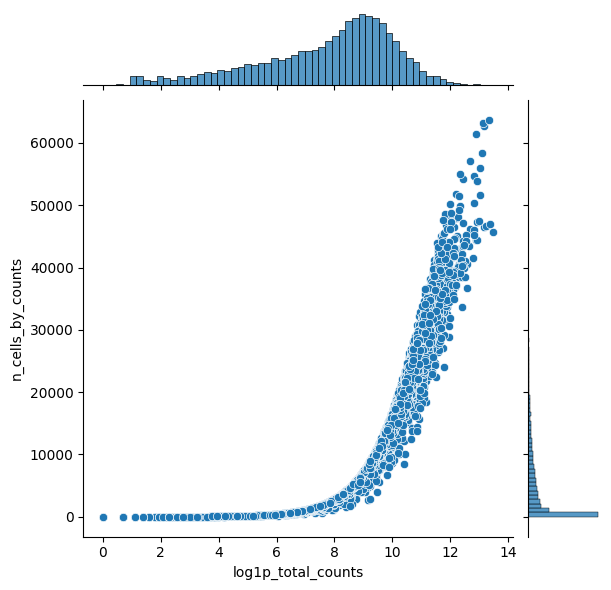

In [120]:
sns.jointplot(filtered_mtx.var,y='n_cells_by_counts',x='log1p_total_counts')

In [124]:
filtered_mtx.var[filtered_mtx.var.total_counts<=3].n_cells_by_counts.describe()

count    271.000000
mean       2.346863
std        0.670530
min        0.000000
25%        2.000000
50%        2.000000
75%        3.000000
max        3.000000
Name: n_cells_by_counts, dtype: float64

In [126]:
filtered_mtx.var.shape

(17926, 8)

In [127]:
sc.pp.filter_genes(filtered_mtx, min_counts=3)

In [128]:
filtered_mtx.var.shape

(17780, 9)

In [129]:
scvi.data.poisson_gene_selection(filtered_mtx)

C:\Users\Daniel\anaconda3\envs\Finances\lib\abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)


Sampling from binomial...: 100%|██████████████████████████████████████████████| 10000/10000 [00:00<00:00, 24641.72it/s]


In [130]:
filtered_mtx.var

,gene_name,mt,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,n_counts,highly_variable,observed_fraction_zeros,expected_fraction_zeros,prob_zero_enriched_nbatches,prob_zero_enrichment,prob_zero_enrichment_rank
Gene_0,FO538757.2,False,14778,0.266911,0.236582,79.078064,18853.0,9.844481,18853.0,True,0.790781,0.796570,1,0.1618,14770.0
Gene_1,SAMD11,False,118,0.001699,0.001697,99.832942,120.0,4.795791,120.0,False,0.998329,0.998305,0,0.0014,2049.0
Gene_2,NOC2L,False,9000,0.153354,0.142674,87.258261,10832.0,9.290352,10832.0,False,0.872583,0.870004,0,0.1096,12541.0
Gene_3,KLHL17,False,1335,0.019495,0.019307,98.109975,1377.0,7.228388,1377.0,False,0.981100,0.980941,0,0.0186,5982.0
Gene_4,PLEKHN1,False,17,0.000241,0.000241,99.975932,17.0,2.890372,17.0,False,0.999759,0.999759,0,0.0002,754.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Gene_17921,C21orf58,False,1730,0.025399,0.025081,97.550755,1794.0,7.492760,1794.0,False,0.975508,0.975336,0,0.0215,6295.0
Gene_17922,PCNT,False,10969,0.196449,0.179358,84.470652,13876.0,9.537988,13876.0,False,0.844707,0.840289,0,0.1363,13774.0
Gene_17923,DIP2A,False,13896,0.260243,0.231305,80.326755,18382.0,9.819181,18382.0,True,0.803268,0.800475,1,0.1597,14703.0
Gene_17924,S100B,False,5536,0.102118,0.097234,92.162415,7213.0,8.883779,7213.0,False,0.921624,0.908799,0,0.0866,11243.0


In [131]:
selected = filtered_mtx[:, filtered_mtx.var["highly_variable"]].copy()

In [132]:
selected

AnnData object with n_obs × n_vars = 70634 × 4000
    obs: 'TAG', 'projid', 'pre.cluster', 'broad.cell.type', 'Subcluster', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_100_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'stage'
    var: 'gene_name', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'highly_variable', 'observed_fraction_zeros', 'expected_fraction_zeros', 'prob_zero_enriched_nbatches', 'prob_zero_enrichment', 'prob_zero_enrichment_rank'
    uns: 'pca', 'neighbors', 'umap', 'broad.cell.type_colors', 'Subcluster_colors', 'projid_colors', 'stage_colors', 'log1p', 'hvg'
    obsm: 'tsne', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'log1p_norm'
    obsp: 'distances', 'connectivities'

In [133]:
selected.write("../cleaned_file/selected_data.h5ad", compression="gzip")

# differential gene analysis

In [ ]:
scvi.model.SCVI.setup_anndata(
    selected, layer="counts", 
)  # prepare data for scVI